Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 0.2599
Epoch 2/10, Loss: 0.1663
Epoch 3/10, Loss: 0.8337
Epoch 4/10, Loss: 0.1663
Epoch 5/10, Loss: 0.1663
Epoch 6/10, Loss: 0.1663
Epoch 7/10, Loss: 0.1663
Epoch 8/10, Loss: 0.1663
Epoch 9/10, Loss: 0.8337
Epoch 10/10, Loss: 0.1663
Accuracy: 0.8333
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


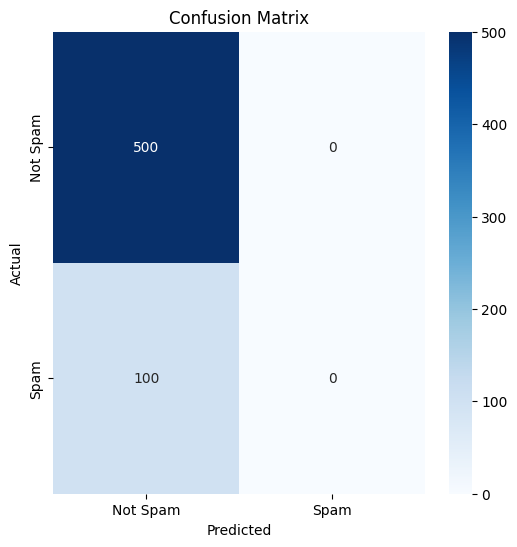

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mounting Google Drive for data access
drive.mount('/content/drive')

# Sigmoid function with clipping to prevent overflow
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -15, 15)))

# Text cleaning function
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower()).split()

# Sentence to embedding conversion
def get_sentence_embedding(sentence, embeddings, max_words=12):
    embedding_dim = len(next(iter(embeddings.values())))
    sentence_embeddings = np.zeros((max_words, embedding_dim))
    for i, word in enumerate(sentence[:max_words]):
        sentence_embeddings[i] = embeddings.get(word, np.zeros(embedding_dim))
    return sentence_embeddings.flatten()

# Neural Network Implementation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.uniform(-1, 1, (input_size, hidden_size)) / np.sqrt(input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.uniform(-1, 1, (hidden_size, output_size)) / np.sqrt(hidden_size)
        self.b2 = np.zeros(output_size)

    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, x, y, y_pred, lr):
        dL_dz2 = y_pred - y
        self.W2 -= lr * np.dot(self.a1.T, dL_dz2)
        self.b2 -= lr * dL_dz2.sum(axis=0)
        dL_dz1 = np.dot(dL_dz2, self.W2.T) * (1 - self.a1 ** 2)
        self.W1 -= lr * np.dot(x.T, dL_dz1)
        self.b1 -= lr * dL_dz1.sum(axis=0)

    def train(self, X, Y, epochs, lr):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = np.mean((y_pred - Y) ** 2)
            self.backward(X, Y, y_pred, lr)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Load word embeddings
embeddings_df = pd.read_csv('/content/drive/MyDrive/word_embeddings.csv', index_col=0)
word_embeddings = {k: np.array(list(v.values())) for k, v in embeddings_df.to_dict(orient='index').items()}

# Load and clean dataset
data = pd.read_csv('/content/drive/MyDrive/spam_or_not_spam.csv').dropna()
data['clean_text'] = data['email'].apply(clean_text)

# Convert sentences to embeddings
X = np.array([get_sentence_embedding(sent, word_embeddings) for sent in data['clean_text']])
Y = data['label'].values.reshape(-1, 1)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and train the neural network
nn = NeuralNetwork(input_size=X_train.shape[1], hidden_size=8, output_size=1)
nn.train(X_train, Y_train, epochs=10, lr=0.01)

# Evaluate the model
y_pred = np.round(nn.forward(X_test))
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, zero_division=0)
recall = recall_score(Y_test, y_pred, zero_division=0)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spam', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
